# Placeholder Title

DSCI 100 010 W2023T2, Group 01 (Thomas Hesselbo, Debon Lee, Coe McGrath, Celine Xi)

### Introduction

 Being able to predict a given student’s knowledge level in a given subject is of pedagogical importance, as it would allow an instructor to identify students who are in need of additional assistance. Subsequently, our project attempts to build a classifier for a student’s level of knowledge utilizing their performance and their study habits in a current subject and its prerequisite subjects. To accomplish this, our project utilizes the “User Knowledge Modeling” dataset sourced from the UC Irvine Machine Learning Repository. This data set contains the variables STG, SCG, STR, LPR, PEG, and UNS. User knowledge (UNS) is classified as either “very low”, “low”, “middle”, or “high”. STG and STR are the normalized study times for current material and prerequisite material respectively. PEG is performance on exams for the current subject. SCG is the extent of repetition undergone by that student for the current subject. Finally, LPR is the student’s knowledge in the prerequisite courses. These variables (STG, SCG, STR, LPR, PEG) are normalized and scaled from 0 to 1, and come pre-split into training and test data sets. 

### Preliminary Data Exploration

#### Loading Packages & Setting the Environment

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Loading the Excel Data

In [2]:
url <- "https://github.com/TheABoss/DSCI-100-2023T2-Project-Group-001/raw/main/data/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
#Define URL object for Excel dataset

temp_xls <- tempfile(fileext = ".xls")
#Prepare temp file

download.file(url, destfile = temp_xls)
#Downloading Excel file

know_train <- read_excel(temp_xls,sheet = 2,range = "A1:F259")
#Downloading Excel sheet as tibble containing training data

know_test <- read_excel(temp_xls,sheet = 3,range = "A1:F146")
#Downloading Excel sheet as tibble containing test data

#### Data Previewing, Cleaning, & Wrangling

In [3]:
know_train
know_test
#Demonstrating file can be read

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


In [4]:
any(is.na(know_train))
any(is.na(know_test))
#Checking for NAs

[1] FALSE

[1] FALSE

The loaded data meets the prerequisites of being tidy (rows = single observations, columns = single variables, one cell = one value). Thus, no cleaning or wrangling was performed as the data is already tidy.

#### Data Summary

##### Table

In [5]:
know_train_avg <- know_train |>
                group_by(UNS) |>
                summarize(avgSTG = mean(STG),
                      avgSCG = mean(SCG),
                      avgSTR = mean(STR),
                      avgLPR = mean(LPR),
                      avgPEG = mean(PEG),
                      Observations = n()) |>
                arrange(desc(avgSTG))
know_train_avg

UNS,avgSTG,avgSCG,avgSTR,avgLPR,avgPEG,Observations
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
High,0.4216508,0.4231905,0.5016667,0.5012698,0.77253968,63
Middle,0.3999773,0.3679205,0.5068182,0.3428409,0.54238636,88
Low,0.3211446,0.3370000,0.4307229,0.4973494,0.23762651,83
very_low,0.3057917,0.1981250,0.3662500,0.3587500,0.09083333,24


##### Plot

`summarise()` has grouped output by 'UNS'. You can override using the `.groups`
argument.


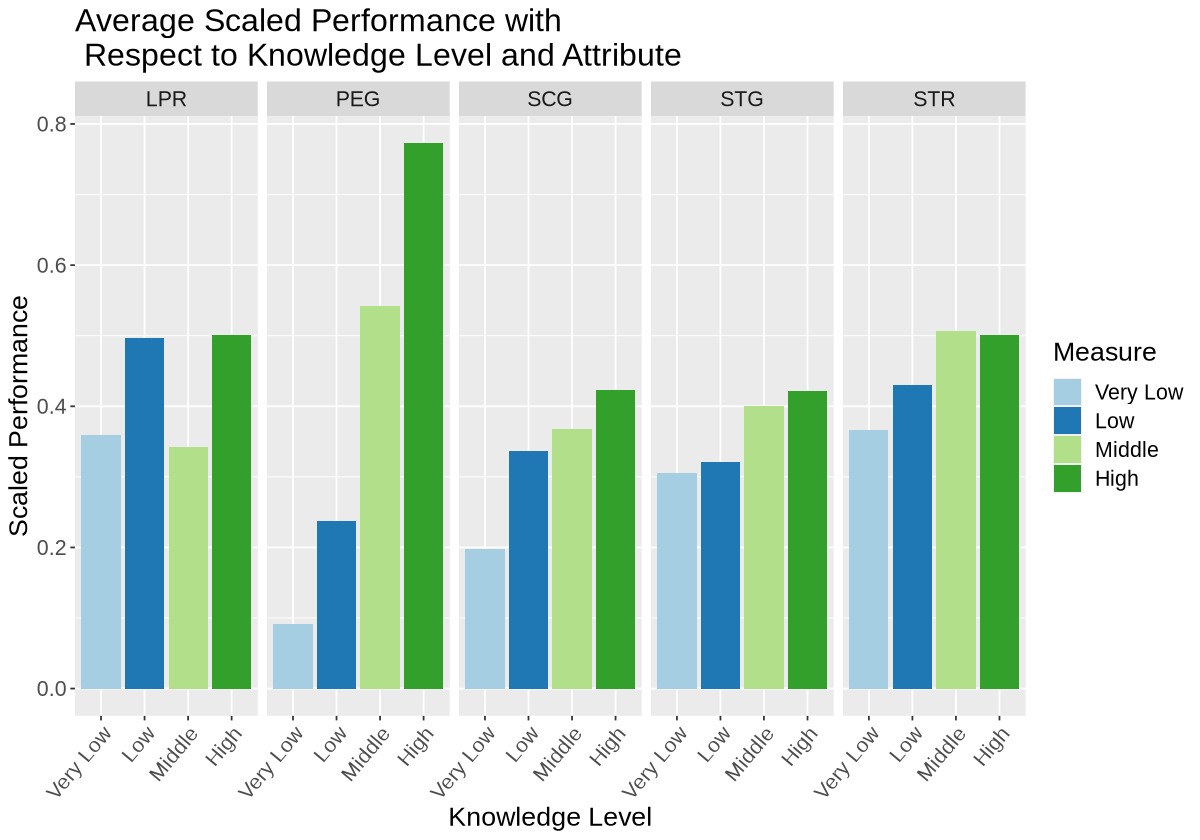

In [6]:
reorder <- know_train |>
            pivot_longer(STG:PEG, names_to = "type", values_to = "value") |>
            group_by(UNS,type) |>
            summarise(avg = mean(value),
                      sd = sd(value))
#Pivoting summmary table such that is no longer untidy (i.e. readable by ggplot)

reorder$UNS <- factor(reorder$UNS, levels = c("very_low", "Low", "Middle", "High"))
#Reorder data from V. Low to High, while also including human-readable labels

options(repr.plot.width = 10, repr.plot.height = 7)
know_train_avg_plot <- ggplot(reorder, aes(x = UNS, 
                                           y = avg, 
                                           fill = UNS)) +
                        geom_bar(stat = "identity", 
                                 position = "dodge") +
                        labs(x = "Knowledge Level", 
                             y = "Scaled Performance", 
                             title = "Average Scaled Performance with\n Respect to Knowledge Level and Attribute",
                             fill = "Measure") +
                        facet_grid(. ~ type) + 
                        scale_x_discrete(labels = c("Very Low", 
                                                    "Low", 
                                                    "Middle", 
                                                    "High")) +
                        scale_fill_brewer(palette = "Paired", 
                                          labels = c("Very Low", 
                                                    "Low", 
                                                    "Middle", 
                                                    "High")) +
                        theme(text = element_text(size = 16), 
                              axis.text.x = element_text(angle = 50, hjust = 1))
know_train_avg_plot

### Methods

To conduct our analysis, we will create a classifier utilizing the K nearest neighbours (KNN) model. The predictors for this model will be STG, SCG, STR, PEG, LPR. We will then demonstrate the results of this analysis through two graphs: one which shows a line graph of the predicted accuracy with different values of k, and a confusion matrix for the final classifier against the test data.

### Expected Outcomes and Significance

We expect that our classifier will have a higher accuracy than the majority classifier and that it will have a high level of recall and precision for each level of knowledge. Should these findings prove significant, it would allow instructors to use this classifier to identify students in need of assistance. Continued work can look to improve the classifier by investigating other predictors for a student’s knowledge levels in a given subject. Additionally, we could also investigate other models (aside from KNN), as they may better predict a student’s level of understanding.